# ADVANCED CHANGE-POINT DETECTION: WORKING WITH DENSITY RATIOS

Welcome to our series about *advanced change-point detection*. In this series we want to explain special topics in the field of change-point detection, sometimes also called change-point analysis.


A brief introduction to change-point analysis can be found in our [introduction notebook](https://github.com/cschroth2/Changepoint-Analysis/blob/master/Change-point-detection-Intro/CP-detection1-intro.ipynb).

Another overview on change-point detection can be found in our [blog series](https://www.iese.fraunhofer.de/blog/change-point-detection/)

In this blog, we want to focus on density ratio methods to detect changes in general. They are known to be an approach for unsupervized change-point detection.

Let's import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from densratio import densratio
from tqdm import tqdm
from statsmodels.tsa.arima_process import ArmaProcess

## 1) Create an example

Let's consider the following example. We define a signal with length 1250 and two change-points at \[250, 500, 750, 1000\].

Note, that the changes won't be visible but the underlying structure in each sequence differs, as it can be seen in the code.

In [2]:
np.random.seed(42) # fix the seed to get deterministic results
signal = np.concatenate([
    np.random.randn(200)+10,
    np.random.randn(200)+5,
    np.random.exponential(1,size=200)+4,
    np.sin(np.linspace(0, 20*np.pi,200)) + np.random.normal(0,0.1,200)+5,
    ArmaProcess(np.array([1, -0.5]), np.array([1])).generate_sample(nsample=200) + 5
])

Let's plot the signal:

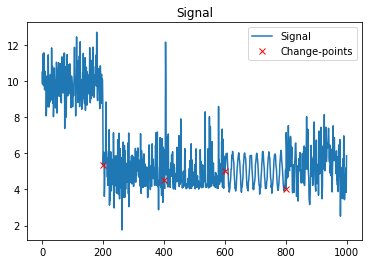

In [3]:
_, ax = plt.subplots()
plt.title('Signal')
plt.plot(signal)
plt.plot([200, 400, 600, 800],signal[[200, 400, 600, 800]],'rx')
plt.legend(['Signal','Change-points']);

## 2) Brief explanation of the density ratio approach

Basically, the density ratio approach works with two sliding windows going through the signal. We have a past window and a future window. In case of a change-point in the future window, there should be a change in the distribution in it. Therefore one tests the hypothesis if the random variables in both windows have the same distribution or not.

But this is difficult to achieve. It is easier to decide, if the *ratio* of the densities is constant or not.

This approach is very general and we only need to set a window length *W*.

Define the window length W:

In [4]:
W = 50 # must be integer >2

The following procedure may take a few minutes, depending on the choice of W:

In [5]:
# allocate memory
costs_kl,costs_pe = np.zeros(len(signal)),np.zeros(len(signal))
# a sliding window through the signal
for i in tqdm(range(W,len(signal)-2*W), desc='Status'):
    x_past,y_future = signal[i:i+W], signal[i+W:i+2*W]
    cost=densratio(x_past, y_future,
                   sigma_range=[0.1, 0.2, 0.4, 0.8, 1.6],
                   lambda_range=[0.01, 0.02, 0.04, 0.08, 0.16],
                   verbose=False)
    costs_kl[i+W],costs_pe[i+W] = cost.alpha_KL,cost.alpha_PE 

Status: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [10:15<00:00,  1.38it/s]


Plot the results. Note, that a ***upper peak*** indicates a change-point.

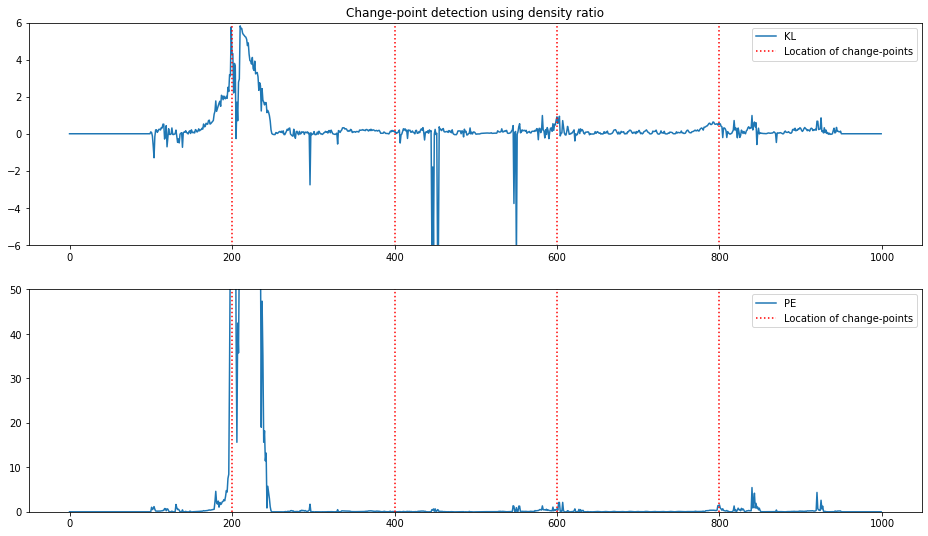

In [6]:
# TODO add vlines for the change-points
_, ax = plt.subplots(nrows=2,figsize=(16, 9))
ax[0].set_title('Change-point detection using density ratio')
ax[0].plot(costs_kl)
ax[0].vlines((200,400,600,800),-8,8, linestyles="dotted", colors="red")
ax[0].set_ylim([-6,6])
ax[0].legend(['KL','Location of change-points'])
ax[1].plot(costs_pe)
ax[1].set_ylim([0,50])
ax[1].vlines((200,400,600,800),0,50, linestyles="dotted", colors="red")
ax[1].legend(['PE','Location of change-points']);

## 3) Discussion

The plot above indicates that a change in mean can be detected easily by a density ratio method. The change to a sinus-like function (intervall 600-800) is also recognized, though not that clear. 

But the change from a Gaussian random variable to an exponential random variable (intervall 400-600) is not recognized. 

#### Advantages:

- Work on a generic level, no expertise domain required
- Need no input but a window size *W*

#### Shortcomings

- Some approaches use kernel functions. As there are infinitely many of them it is not clear how to tune hyperparameters.

## 4) Literature

- Adiga, Sudarshan, and Ravi Tandon. "Unsupervised Change Detection using DRE-CUSUM." arXiv preprint arXiv:2201.11678 (2022).
- Aminikhanghahi, Samaneh; Cook, Diane J. (2017): A Survey of Methods for Time Series Change Point Detection. In Knowledge and information systems 51 (2), pp. 339–367. DOI: 10.1007/s10115-016-0987-z.